In [1]:
cd ..

/home/ias627/projects/massive_halos


In [2]:
from scripts.halo_analysis_scripts import *
from tqdm import tqdm
from joblib import Parallel, delayed
from astropy import units as un, constants as cons
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.misc import derivative
import pickle
%matplotlib inline
plt.rcParams['figure.dpi'] = 110

In [3]:
d = '/projects/b1026/isultan/fire3/m13h206_m3e5_MHDCRspec1_fire3_fireBH_fireCR1_Oct252021_crdiffc1_sdp1e-4_gacc31_fa0.5_fcr1e-3_vw3000/'

In [4]:
p = load_allparticles(d, 60, Rvir='find_Rvir_SO', loud=0)

In [5]:
pall = {}
pall['posC'] = p[1]['posC']
pall['Coordinates'] = np.concatenate([p[k]['Coordinates'] for k in p.keys()])
pall['Masses'] = np.concatenate([p[k]['Masses'] for k in p.keys()])
pall['r'] = np.linalg.norm(pall['Coordinates'] - pall['posC'], axis=1)
asort = np.argsort(pall['r'])

(-1.1019141898499973,
 1.105715601213818,
 -1.1063330308089077,
 1.1003015728956622)

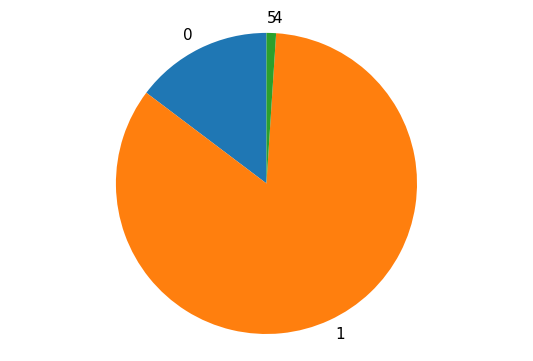

In [7]:
labels = list(p.keys())
sizes = [np.sum(p[k]['Masses']) for k in p.keys()]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')

In [8]:
def pot(p, x):
    CoordinatesRelative = p['Coordinates'] - p['posC']
    r = np.linalg.norm(CoordinatesRelative - x, axis=1)
    return np.sum(p['Masses']/r)

In [9]:
def sample_sphere(rho, Nangle=50):
    pts = np.array([(rho*np.cos(theta)*np.sin(phi), rho*np.sin(theta)*np.sin(phi), rho*np.cos(phi)) for theta in np.linspace(0,np.pi,Nangle) for phi in np.linspace(0,2*np.pi,Nangle)])
    return pts

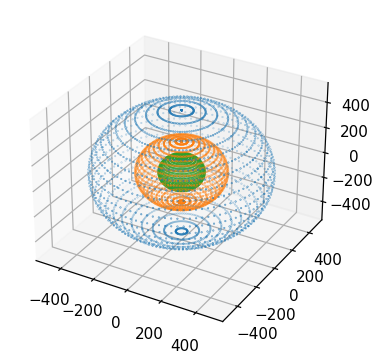

In [10]:
ax = plt.axes(projection='3d')

pts = sample_sphere(p[1]['Rvir'])
ax.scatter3D(pts[:,0], pts[:,1], pts[:,2], s=.1)

pts = sample_sphere(p[1]['Rvir']/2)
ax.scatter3D(pts[:,0], pts[:,1], pts[:,2], s=.1)

pts = sample_sphere(p[1]['Rvir']/4)
ax.scatter3D(pts[:,0], pts[:,1], pts[:,2], s=.1)

In [11]:
pot_ptype1 = [np.mean(Parallel(n_jobs=-1)(delayed(pot)(p[1], pt) for pt in sample_sphere(rho, 10))) for rho in tqdm(np.linspace(1,p[1]['Rvir']))]
pot_pall = [np.mean(Parallel(n_jobs=-1)(delayed(pot)(pall, pt) for pt in sample_sphere(rho, 10))) for rho in tqdm(np.linspace(1,p[1]['Rvir']))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:21<00:00,  6.43s/it]


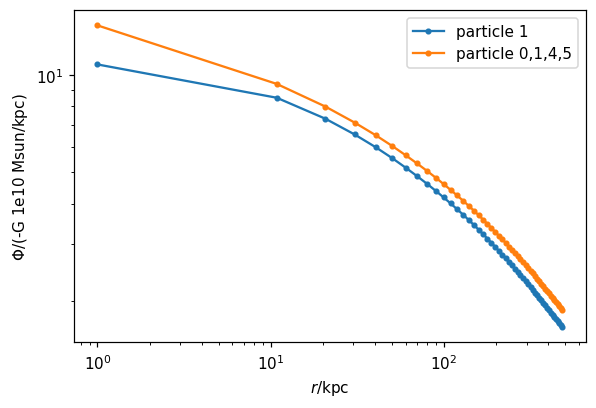

In [51]:
plt.plot(np.linspace(1,p[1]['Rvir']), pot_ptype1, '.-', label='particle 1')
plt.plot(np.linspace(1,p[1]['Rvir']), pot_pall, '.-', label='particle 0,1,4,5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$/kpc')
plt.ylabel('$\Phi$/(-G 1e10 Msun/kpc)')
plt.legend()

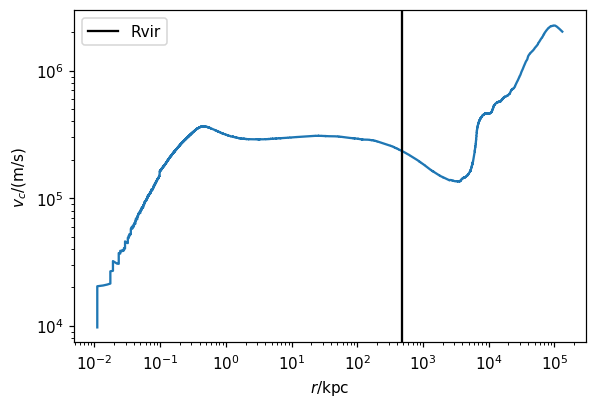

In [10]:
vc = (np.sqrt(np.cumsum(pall['Masses'][asort])*1e10/pall['r'][asort]) * (cons.G*un.Msun/un.kpc)**0.5).si.value #m/s
plt.plot(pall['r'][asort], vc)
# plt.xlim(1,2*p[1]['Rvir'])
plt.axvline(p[1]['Rvir'], label='Rvir', c='k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$/kpc')
plt.ylabel('$v_c$/(m/s)')
plt.legend()

## Integrate

In [6]:
3 * p[1]['Rvir']

1448.8006896972656

In [7]:
p[1]['Rvir']

482.93356

In [ ]:
Rmin = 0.01
Rmax = 10 * p[1]['Rvir']
rbins = np.logspace(np.log10(Rmin), np.log10(Rmax), 100)

Mrbins = np.array([np.sum(pall['Masses'][pall['r']<=r]) for r in rbins]) * 1e10 #M(r) for r in rbins were [M]=Msun and [r]=kpc
dicttoh5({'r':rbins, 'M(r)':Mrbins, 'Rvir':p[1]['Rvir']}, 'Mr.h5', mode='w')

#Mr_interp = interp1d(rbins, Mrbins) #M(r) where [M]=1e10 Msun and [r]=kpc
#pickle.dump( Mr_interp, open( "Mr_interp.p", "wb" ) )

(0.1, 1448.8006896972656)

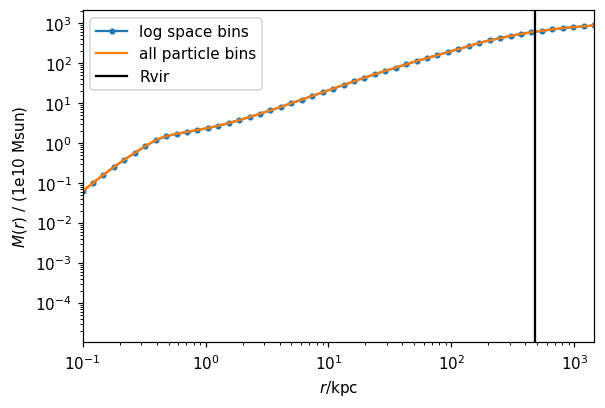

In [116]:
plt.plot(rbins, Mrbins, '.-', label='log space bins')
plt.plot(pall['r'][asort][pall['r'][asort]<Rmax], np.cumsum(pall['Masses'][asort])[pall['r'][asort]<Rmax], '-', label='all particle bins')

plt.axvline(p[1]['Rvir'], label='Rvir', c='k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$/kpc')
plt.ylabel('$M(r)$ / (1e10 Msun)')
plt.legend()

plt.xlim(Rmin, Rmax)

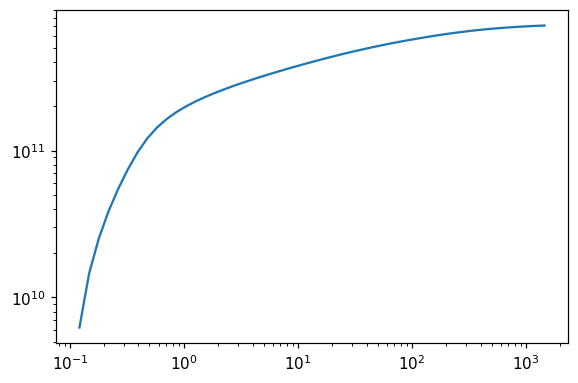

In [144]:
dr = rbins[1:] - rbins[:-1]
plt.plot(rbins[1:], np.cumsum((Mrbins / rbins**2)[1:] * dr * (1e10*cons.G*un.Msun/un.kpc).si.value))

plt.xscale('log')
plt.yscale('log')

In [174]:
integrand = lambda r : Mr_interp(r) / r**2
Phir = lambda r : quad(integrand, Rmin, r)[0] - quad(integrand, Rmin, Rmax)[0]

vcr = lambda r : np.sqrt(Mr_interp(r)/r)

lnvcr = lambda x : np.log( np.sqrt(Mr_interp(np.exp(x))/np.exp(x)) )

/tmp/ipykernel_193841/721661156.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Phir = lambda r : quad(integrand, Rmin, r)[0] #- quad(integrand, Rmin, Rmax)[0]
/tmp/ipykernel_193841/721661156.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Phir = lambda r : quad(integrand, Rmin, r)[0] #- quad(integrand, Rmin, Rmax)[0]


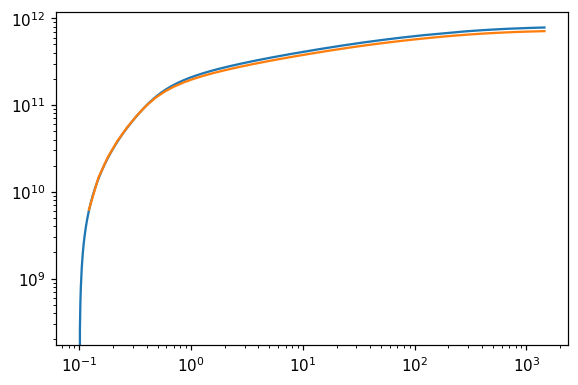

In [164]:
rbins2 = np.logspace(np.log10(Rmin), np.log10(Rmax), 1000)
plt.plot(rbins2, np.array([Phir(r) for r in rbins2]) *  (1e10*cons.G*un.Msun/un.kpc).si.value)

plt.plot(rbins[1:], np.cumsum((Mrbins / rbins**2)[1:] * dr * (1e10*cons.G*un.Msun/un.kpc).si.value))
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_193841/2407634942.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Phir = lambda r : quad(integrand, Rmin, r)[0] - quad(integrand, Rmin, Rmax)[0]


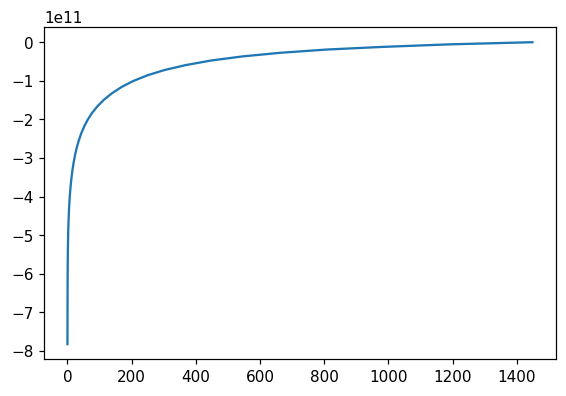

In [176]:
plt.plot(rbins, np.array([Phir(r) for r in rbins]) *  (1e10*cons.G*un.Msun/un.kpc).si.value)

## $\dot{M}$ FIRE-3 calculation

In [10]:
def sim_path_fire3_quest(filename):
    filebase = '/projects/b1026/snapshots/fire3'
    if filename == 'm13h02_m3e5_MHD_fire3_fireBH_Sep052021_crdiffc690_sdp1e-4_gacc31_fa0.5':
        simbase = 'm13h002_m3e5'
    elif filename == 'm13h29_m3e5_MHD_fire3_fireBH_Sep052021_crdiffc690_sdp1e-4_gacc31_fa0.5':
        simbase = 'm13h/029_m3e5'
    else:
        simbase = '_'.join( filename.split('_')[:2] )
    return os.path.join(filebase, simbase,  filename)

In [13]:
def Mdot_profile(d):
    p = load_allparticles(d, 60, 
                          particle_types=[0,1], 
                          keys_to_extract={0:['Coordinates', 'Masses', 'Velocities'],1:['Coordinates', 'Masses']}, 
                          Rvir='find_Rvir_SO', loud=0)
    ''' 
    *** Units ***
    Coordinates: pkpc
    Masses: 1e10 Msun
    Velocities: pkm/s
    Rvir: pkpc
    Mvir: Msun
    '''

    v = p[0]['Velocities']
    r = p[0]['Coordinates'] - p[0]['posC']
    r_mag = np.linalg.norm(r, axis=1)
    p[0]['vrad'] = np.sum(v*r, axis=1) / r_mag # Same units as Velocities

    Rmin = 0.1
    Rmax = 1500 #3 * p[0]['Rvir']
    rbins = np.logspace(np.log10(Rmin), np.log10(Rmax), 100) #pkpc
    rmid = (rbins[:-1]+rbins[1:])/2 #in units of pkpc
    Tmask=True

    Mdot_profile = [] #in units of Msun/yr

    for r0,r1 in zip(rbins[:-1],rbins[1:]):
        dL = r1 - r0
        idx = np.flatnonzero(Tmask & inrange( r_mag, (r0, r1) ))

        # Mdot profile: Msun/yr
        Mdot = np.sum(p[0]['vrad'][idx] * 1e10 * p[0]['Masses'][idx] / dL ) * (un.km / un.s * un.Msun / un.kpc).to(un.Msun / un.yr)
        Mdot_profile.append(Mdot)

    return np.array(Mdot_profile)

In [14]:
fire3dirs = [sim_path_fire3_quest(f) for f in np.genfromtxt('sims_frontera_fire3.txt', dtype=str)]

In [15]:
Mdot_profile(fire3dirs[5])

OSError: Snapshot 60 not found in /projects/b1026/snapshots/fire3/m13h029_m3e5/m13h029_m3e5_MHDCRspec1_fire3_fireBH_fireCR1_Oct252021_crdiffc1_sdp1e-4_gacc31_fa0.5_fcr1e-3_vw3000/output/

In [ ]:
d = '/projects/b1026/isultan/fire3/m13h206_m3e5_MHDCRspec1_fire3_fireBH_fireCR1_Oct252021_crdiffc1_sdp1e-4_gacc31_fa0.5_fcr1e-3_vw3000/'
d = '/projects/b1026/isultan/fire3/m13h206_m3e5_MHD_fire3_fireBH_Sep182021_crdiffc690_sdp1e10_gacc31_fa0.5/'

In [113]:
p = load_allparticles(d, 60, 
                      particle_types=[0,1], 
                      keys_to_extract={0:['Coordinates', 'Masses', 'Velocities'],1:['Coordinates', 'Masses']}, 
                      Rvir='find_Rvir_SO', loud=0)
''' 
*** Units ***
Coordinates: pkpc
Masses: 1e10 Msun
Velocities: pkm/s
Rvir: pkpc
Mvir: Msun
'''

' \n*** Units ***\nCoordinates: pkpc\nMasses: 1e10 Msun\nVelocities: pkm/s\nRvir: pkpc\nMvir: Msun\n'

In [115]:
v = p[0]['Velocities']
r = p[0]['Coordinates'] - p[0]['posC']
r_mag = np.linalg.norm(r, axis=1)
p[0]['vrad'] = np.sum(v*r, axis=1) / r_mag # Same units as Velocities

In [129]:
Rmin = 0.1
Rmax = 1500 #3 * p[0]['Rvir']
rbins = np.logspace(np.log10(Rmin), np.log10(Rmax), 100) #pkpc
# rbins = np.linspace(Rmin, Rmax, 100) #pkpc
rmid = (rbins[:-1]+rbins[1:])/2 #in units of pkpc
Tmask=True

Mdot_profile = []

for r0,r1 in zip(rbins[:-1],rbins[1:]):
    dL = r1 - r0
    idx = np.flatnonzero(Tmask & inrange( r_mag, (r0, r1) ))

    # Mdot profile: Msun / yr
    Mdot = np.sum(p[0]['vrad'][idx] * 1e10 * p[0]['Masses'][idx] / dL ) * (un.km / un.s * un.Msun / un.kpc).to(un.Msun / un.yr)
    Mdot_profile.append(Mdot)

Text(0, 0.5, '$\\dot{M}$ / ($M_\\odot$/yr)')

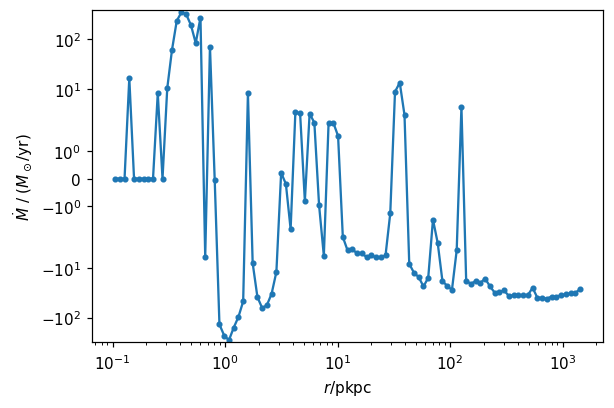

In [130]:
plt.plot(rmid, Mdot_profile, '.-')
plt.xscale('log')
plt.yscale('symlog')

plt.xlabel('$r$/pkpc')
plt.ylabel('$\dot{M}$ / ($M_\odot$/yr)')
# plt.legend()